# Mass Identification with B8 Background

## Import packages and define functions

In [2]:
import ROOT
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.interpolate as ip
from matplotlib.ticker import MultipleLocator
from scipy.stats import poisson
import uproot
import glob

Welcome to JupyROOT 6.20/04


Tip: 

to check headers in RooArgSet: row.Print()

In [124]:
#from https://gitlab.com/luxzeplin/stats/LowE_NR_group/-/blob/master/notebooks/modules/LZBANDS.py#L230
def read_data_from_RooDataSet(file_path, object_name):
    ''' 
    Read data from a ROOT.RooDataSet object
    '''
    f = ROOT.TFile(file_path)
    dataset = f.Get(object_name)
    nSamples = int(dataset.sumEntries())
    X = np.zeros(nSamples, dtype=float) 
    Y = np.zeros(nSamples, dtype=float)
    for i in range(nSamples):
        row = dataset.get(i)
        X[i] = row.getRealValue('S1')
        Y[i] = row.getRealValue('log_S2')

    f.Close()
    return X,Y


In [125]:
#some uproot
def read_histogram(file_name):
    root_model_file = uproot.open(file_name)
    values, xEdges, yEdges = root_model_file['h_S1logS2'].to_numpy()
    return values,xEdges,yEdges

In [126]:
#mean_background_count: scalar, mean background count per cell (after scaled with the scaling ratio returned by get_scaling_ratio)
#mean_signal_count: scalar, mean signal count per cell (after scaled with the scaling ratio returned by get_scaling_ratio)
#observed_count: scalar, observed count per cell
#return: P(n|mu)
#called in other functions
#Eq 3.2 from Feldman and Cousins

def get_poisson_probability(mean_background_count, mean_signal_count, observed_count):
    return poisson.pmf(observed_count, mean_background_count+mean_signal_count)
    #poission_probability = (mean_signal_count+mean_background_count)**observed_count*np.exp(-(mean_signal_count+mean_background_count))/(np.math.factorial(n))

In [127]:
#expected_count: scalar. 21 for background; free-floating for signal
#called in other functions
def get_scaling_ratio(histogram_values, expected_count):
    total_histogram_count = np.sum(histogram_values) #sum over all the elements in the matrix
    return expected_count/total_histogram_count

In [128]:
#store the read histogram to save time (trading time with affordable space)
def read_model_histograms(model_name_list):
    values_list = []
    xEdges_list = []
    yEdges_list = []
    for model_name in model_name_list:
        values, xEdges, yEdges = read_histogram(model_name)
        values_list.append(values)
        xEdges_list.append(xEdges)
        yEdges_list.append(yEdges)
        
    return values_list,xEdges_list,yEdges_list

In [129]:
#calculate n_i for each cell in the 2d histogram
def get_ni(xEdges,yEdges,data_file_path,data_object_name):
    S1_value,logS2_value = read_data_from_RooDataSet(data_file_path,data_object_name)
    n_matrix = [] #2D matrix: list of lists with different S1_index; then each element in the list has a different logS2_index
    for S1_index in range(len(xEdges)-1):
        n_matrix.append([])
        for S2_index in range(len(yEdges)-1):
            n_matrix[S1_index].append(0)
            for event_index in range(len(S1_value)): #looping events here to save computation time
                if (S1_value[event_index]>xEdges[S1_index] and  S1_value[event_index]<xEdges[S1_index+1]) or S1_value[event_index]==xEdges[S1_index]:
                    if (logS2_value[event_index]>yEdges[S2_index] and logS2_value[event_index]<yEdges[S2_index+1]) or logS2_value[event_index]==yEdges[S2_index]:
                        n_matrix[S1_index][S2_index] = n_matrix[S1_index][S2_index]+1
                        
    return np.array(n_matrix)

In [246]:
#returns the poisson probability matrix and the maximum poisson probability matrix to be used in Eq 5.4 from Feldman and Cousins
def get_poisson_probability_matrix(value_list,background_file_path, background_file_name, n_matrix):
    expected_count_upper_bound = 55 #strict upper bound (not included)
    expected_count_lower_bound = 45 #included
    value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)
    scaling_ratio_bg = get_scaling_ratio(value_bg,21)
    poisson_probability_matrix = np.zeros((len(value_list),expected_count_upper_bound-expected_count_lower_bound,len(xEdges_bg)-1,len(yEdges_bg)-1)) #4D matrix: list of 3D matrices with different mass index; each 3D matrix is a list of 2D matrices with different expected count; each matrix is a list of lists with different S1_index; then each element in the list has  a different logS2_index
    poisson_probability_max_matrix = np.zeros((len(xEdges_bg)-1,len(yEdges_bg)-1)) #2D matrix: list of lists with different S1_index; then each element in the lists has a different logS2_index
    R_matrix = np.zeros((len(value_list),expected_count_upper_bound-expected_count_lower_bound,len(xEdges_bg)-1,len(yEdges_bg)-1))
    for mass_index in range(len(value_list)): #variable to fit
        expected_count_index = -1
        for expected_count in range(expected_count_lower_bound,expected_count_upper_bound): #free floating variable to fit
            print(expected_count)
            expected_count_index = expected_count_index+1
            scaling_ratio_sig = get_scaling_ratio(value_list[mass_index],expected_count)
            for S1_index in range(len(value_list[mass_index])):
                for logS2_index in range(len(value_list[mass_index][S1_index])):
                    #notation from Feldman and Cousins poisson with background
                    n_i = n_matrix[S1_index][logS2_index]
                    mu_i = value_list[mass_index][S1_index][logS2_index]*scaling_ratio_sig
                    b_i = value_bg[S1_index][logS2_index]*scaling_ratio_bg
                    #if n_i == 0: #assigning zero to cells with zero observed counts
                         #poisson_probability_matrix[mass_index][expected_count_index][S1_index][logS2_index] = 0
                    #else:
                    poisson_probability = get_poisson_probability(b_i, mu_i, n_i)
                    poisson_probability_matrix[mass_index][expected_count_index][S1_index][logS2_index] =  poisson_probability #store the probability. To be used in Eq 5.4
                        #check if we need to overwrite the maximum poisson probability. To be used in Eq 5.4
                    if poisson_probability>poisson_probability_max_matrix[S1_index][logS2_index]:
                        poisson_probability_max_matrix[S1_index][logS2_index] = poisson_probability
                        
    R_matrix_returned,R_matrix_summed = get_R(R_matrix, poisson_probability_matrix,poisson_probability_max_matrix)
    return poisson_probability_matrix,poisson_probability_max_matrix,R_matrix_returned,R_matrix_summed

In [131]:
#Eq 5.4 from Feldman and Cousins
#poisson_probability_matrix and poisson_probability_max_matrix from get_poisson_probability_matrix
#called in get_poisson_probability_matrix
def get_R(R_matrix, poisson_probability_matrix,poisson_probability_max_matrix):
    R_matrix_summed = [] #2D matrix: list of lists with different S1_index; each element the lists has a different logS2_index
    for mass_index in range(len(R_matrix)):
        R_matrix_summed.append([])
        for expected_count_index in range(len(R_matrix[mass_index])):
            for S1_index in range(len(R_matrix[mass_index][expected_count_index])):
                for logS2_index in range(len(R_matrix[mass_index][expected_count_index][S1_index])):
                    if poisson_probability_max_matrix[S1_index][logS2_index] != 0: #to prevent errors from dividing by zero, leave the element as 0 otherwise
                        R_matrix[mass_index][expected_count_index][S1_index][logS2_index] = poisson_probability_matrix[mass_index][expected_count_index][S1_index][logS2_index]/poisson_probability_max_matrix[S1_index][logS2_index]
            R_matrix_summed[mass_index].append(np.sum(R_matrix[mass_index][expected_count_index]))
    return R_matrix,np.array(R_matrix_summed)

In [132]:
#final method
#identify the fitted parameters: mass and expected count
#R_matrix_summed is an np.ndarray from get_R
#the np array argmax documentation is more complicated than coding it myself
def get_fitted_parameters(R_matrix_summed):
    max_R = np.amax(R_matrix_summed) #initialization
    max_index_list = [] #list of lists, each sub-list is in the form of [mass_index,expected_count]
    for mass_index in range(len(R_matrix_summed)):
        for expected_count_index in range(len(R_matrix_summed[mass_index])):
            if R_matrix_summed[mass_index][expected_count_index] == max_R:
                max_index_list.append([mass_index,expected_count_index])
    return np.array(max_index_list)

## Define file names

In [133]:
model_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
model_names = glob.glob(model_path+'/wimp_pdf_*.root')
print(model_names)

['/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m11.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m508.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m1420.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m40.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m16.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m716.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m32.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m361.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m1008.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m2000.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m129.root', '/global/cfs/cdirs/lz/data/LZSta

In [257]:
data_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/mysterious_data/mock_data_v2.root'
data_object_name = 'obs_data'

background_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
background_file_name = 'background_pdf_8B.root'

## Fitting

In [258]:
#load model pdfs for wimps with different mass
model_value_list,model_xEdges_list,model_yEdges_list = read_model_histograms(model_names)

In [259]:
n_matrix = get_ni(model_xEdges_list[0],model_yEdges_list[0],data_file_path,data_object_name)

In [260]:
poisson_probability_matrix,poisson_probability_max_matrix,R_matrix_returned,R_matrix_summed = get_poisson_probability_matrix(model_value_list,background_file_path, background_file_name, n_matrix)

45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54
45
46
47
48
49
50
51
52
53
54


In [261]:
max_index_matrix = get_fitted_parameters(R_matrix_summed)

In [262]:
for i in range(len(max_index_matrix)):
    print(model_names[max_index_matrix[i][0]]+' '+str(max_index_matrix[i][1]))

/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m508.root 0


## Construction zone

In [156]:
value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)

In [157]:
value_bg

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
data_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/mysterious_data/mock_data_v2.root'
data_object_name = 'obs_data'

testarray0,testarray1 = read_data_from_RooDataSet(data_file_path,data_object_name)

In [94]:
print(len(testarray0))

70


In [95]:
testarray0

array([ 1.82287781, 61.07915819, 43.63206466,  2.65570476,  4.07349728,
       76.05697483, 45.32135741,  2.67652236,  3.08518398, 31.73636507,
        2.05164038, 24.01193481,  5.04517215, 35.91551854, 46.53079723,
       20.50274685, 15.98330736, 49.61558889,  2.28036733,  4.53663523,
       21.76729271, 45.02115167, 14.4701466 ,  2.55523063, 12.78731358,
        3.46900592,  3.22412088,  2.55973639, 11.39397119, 19.43801389,
        7.80654741, 43.18112631, 41.25700353,  3.0421562 , 10.12736812,
        5.46912881, 53.95610311,  3.37344421, 20.33903844, 14.45895582,
        3.22203956,  2.62627476, 10.71388342,  6.55023676,  2.98935526,
        7.48734044, 52.55338619,  3.76535986,  4.90711547, 26.90379185,
        9.91202557, 24.24339461, 28.17885212, 39.43660664,  3.54659385,
        5.41755691, 44.61870213,  8.21970507, 55.82875209, 15.80424956,
        4.26188774, 14.93387537, 42.44262781, 37.74305432,  9.63697644,
       48.274916  ,  5.77238994,  8.83700218, 47.14078591, 36.00

In [ ]:
total_observed_background_count = 21 #observed and expected
#total_observed_signal_count = 50-21 #observed and expected

In [110]:
model_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
model_name = 'wimp_pdf_m1008.root'
#'wimp_pdf_m1008.root'

In [111]:
root_model_file = uproot.open(model_path+model_name)

In [112]:
root_model_file.classnames()

{'h_S1logS2;1': 'TH2D', 'h_r2z;1': 'TH2D'}

In [113]:
values, xEdges, yEdges = root_model_file['h_S1logS2'].to_numpy()

In [115]:
xEdges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80.])

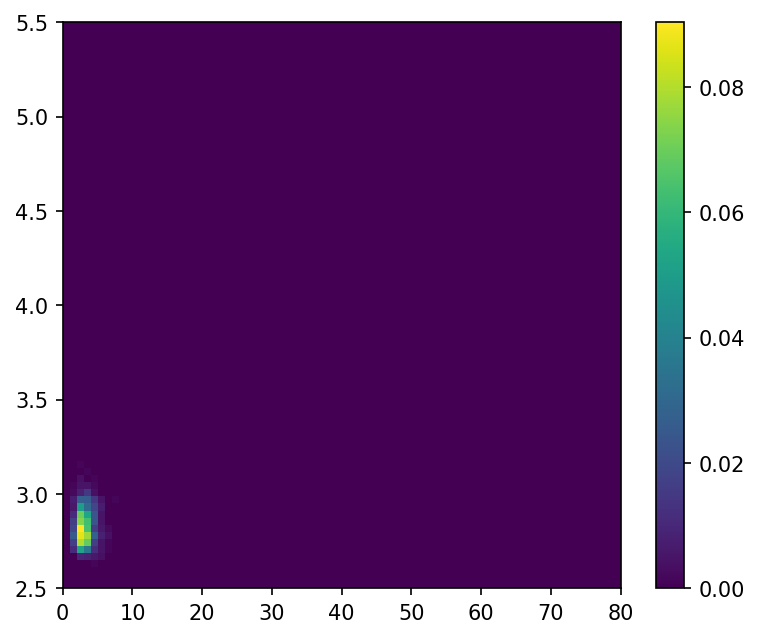

In [158]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xEdges,yEdges,np.transpose(value_bg), zorder=1)
cbar = fig.colorbar(pcm)


In [118]:
np.shape(np.array([[1,2,3],[4,5,6]]))

(2, 3)

In [185]:
test_bg = value_bg*get_scaling_ratio(value_bg,21)

In [186]:
np.shape(test_bg)

(80, 80)

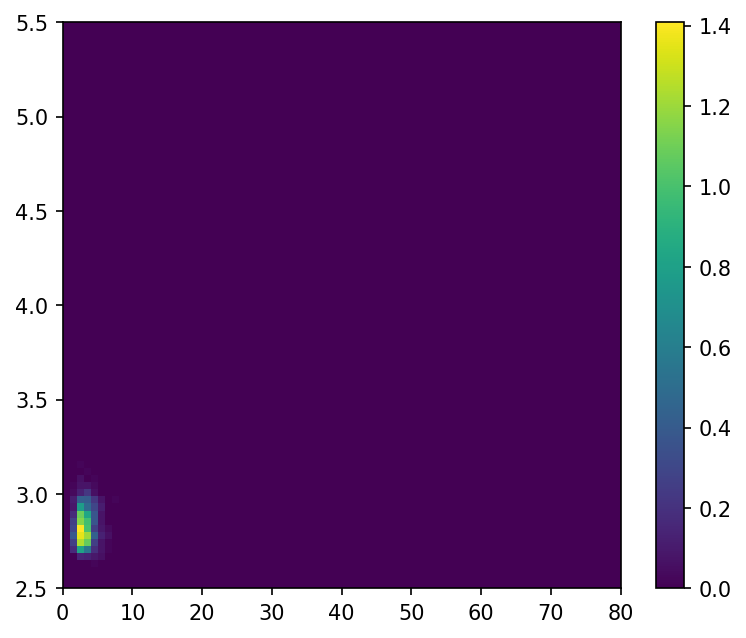

In [189]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xEdges,yEdges,np.transpose(test_bg), zorder=1)
cbar = fig.colorbar(pcm)

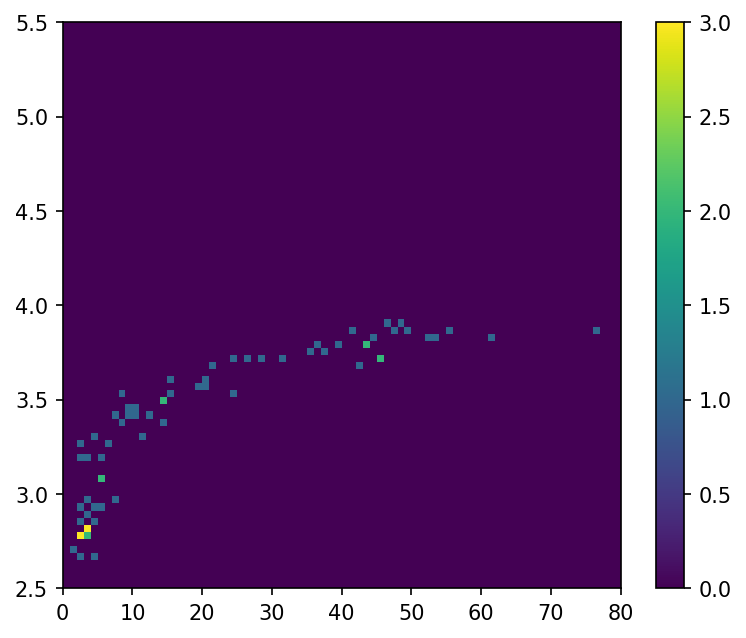

In [190]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xEdges,yEdges,np.transpose(n_matrix), zorder=1)
cbar = fig.colorbar(pcm)

In [191]:
model_path_test = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m716.root'

In [192]:
test_model_values, test_model_xEdges, test_model_yEdges = read_histogram(model_path_test)

In [208]:
test_model = test_model_values*get_scaling_ratio(test_model_values,54)

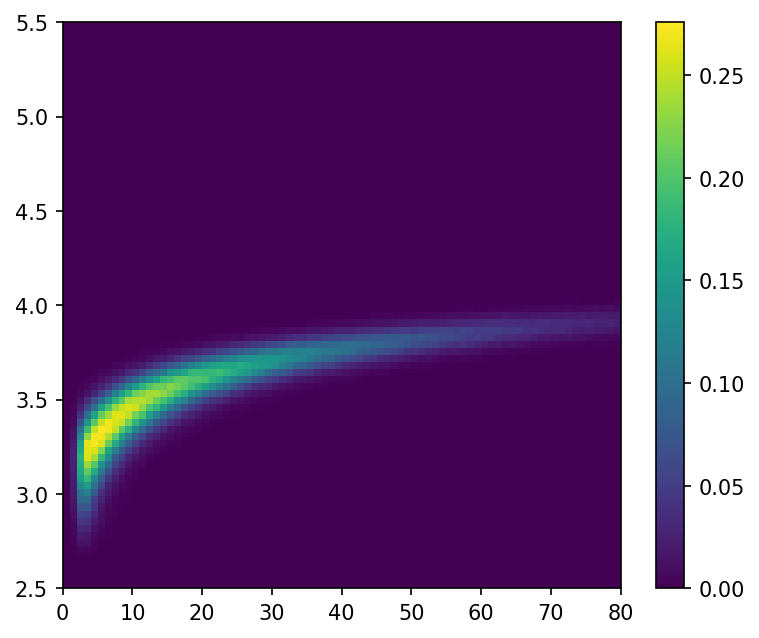

In [209]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xEdges,yEdges,np.transpose(test_model), zorder=1)
cbar = fig.colorbar(pcm)